## Dependencies

In [1]:
pip install spotipy --upgrade

Requirement already up-to-date: spotipy in c:\users\jshar\anaconda3\lib\site-packages (2.18.0)
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import json
import re 
import sys
import itertools

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.oauth2 import SpotifyOAuth
import spotipy.util as util

import warnings
warnings.filterwarnings("ignore")

In [2]:
%matplotlib inline

In [3]:
#If you're not familiar with this, save it! Makes using jupyter notebook on laptops much easier
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
#another useful command to make data exploration easier
# NOTE: if you are using a massive dataset, this could slow down your code. 
pd.set_option('display.max_columns', None)
pd.set_option("max_rows", None)

## Summary:

## 1. Data Exploration/Preparation

Download datasets here:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

In [5]:
spotify_df = pd.read_csv('data.csv')

In [6]:
spotify_df.head()

acousticness                    artists  danceability  duration_ms  energy  \
0      0.991000            ['Mamie Smith']         0.598       168333   0.224   
1      0.643000  ["Screamin' Jay Hawkins"]         0.852       150200   0.517   
2      0.993000            ['Mamie Smith']         0.647       163827   0.186   
3      0.000173        ['Oscar Velazquez']         0.730       422087   0.798   
4      0.295000                   ['Mixe']         0.704       165224   0.707   

   explicit                      id  instrumentalness  key  liveness  \
0         0  0cS0A1fUEUd1EW3FcF8AEI          0.000522    5    0.3790   
1         0  0hbkKFIJm7Z05H8Zl9w30f          0.026400    5    0.0809   
2         0  11m7laMUgmOKqI3oYzuhne          0.000018    0    0.5190   
3         0  19Lc5SfJJ5O1oaxY0fpwfh          0.801000    2    0.1280   
4         1  2hJjbsLCytGsnAHfdsLejp          0.000246   10    0.4020   

   loudness  mode                                               name  \
0   -12.628     0                           Keep A Song In Your Soul   
1    -7.261     0                               I Put A Spell On You   
2   -12.098     1                                       Golfing Papa   
3    -7.311     1  True House Music - Xavier Santos & Carlos Gomi...   
4    -6.036     0                                          Xuniverxe   

   popularity release_date  speechiness    tempo  valence  year  
0          12         1920       0.0936  149.976   0.6340  1920  
1           7   1920-01-05       0.0534   86.889   0.9500  1920  
2           4         1920       0.1740   97.600   0.6890  1920  
3          17   1920-01-01       0.0425  127.997   0.0422  1920  
4           2   1920-10-01       0.0768  122.076   0.2990  1920

Observations:
1. This data is at a **song level**
2. Many numerical values that I'll be able to use to compare movies (liveness, tempo, valence, etc)
2. Release date will useful but I'll need to create a OHE variable for release date in 5 year increments
3. Similar to 2, I'll need to create OHE variables for the popularity. I'll also use 5 year increments here
4. There is nothing here related to the genre of the song which will be useful. This data alone won't help us find relavent content since this is a content based recommendation system. Fortunately there is a `data_w_genres.csv` file that should have some useful information

In [7]:
data_w_genre = pd.read_csv('data_w_genres.csv')
data_w_genre.head()

artists  acousticness  \
0                   "Cats" 1981 Original London Cast      0.598500   
1                          "Cats" 1983 Broadway Cast      0.862538   
2        "Fiddler On The Roof” Motion Picture Chorus      0.856571   
3     "Fiddler On The Roof” Motion Picture Orchestra      0.884926   
4  "Joseph And The Amazing Technicolor Dreamcoat"...      0.510714   

   danceability    duration_ms    energy  instrumentalness  liveness  \
0      0.470100  267072.000000  0.376203          0.010261  0.283050   
1      0.441731  287280.000000  0.406808          0.081158  0.315215   
2      0.348286  328920.000000  0.286571          0.024593  0.325786   
3      0.425074  262890.962963  0.245770          0.073587  0.275481   
4      0.467143  270436.142857  0.488286          0.009400  0.195000   

    loudness  speechiness       tempo   valence  popularity  key  mode  count  \
0 -14.434300     0.209150  114.128800  0.358320   38.200000    5     1     10   
1 -10.690000     0.176212  103.044154  0.268865   31.538462    5     1     26   
2 -15.230714     0.118514   77.375857  0.354857   34.571429    0     1      7   
3 -15.639370     0.123200   88.667630  0.372030   34.407407    0     1     27   
4 -10.236714     0.098543  122.835857  0.482286   42.000000    5     1      7   

           genres  
0  ['show tunes']  
1              []  
2              []  
3              []  
4              []

Observations:
1. This data is at an **artist level**
2. There are similar continuous variables as our initial dataset but I won't use this. I'll just use the values int he previous dataset. 
3. The genres are going to be really useful here and I'll need to use it moving forward. Now, the genre column appears to be in a list format but my past experience tells me that it's likely not. Let's investigate this further.

In [8]:
data_w_genre.dtypes

artists              object
acousticness        float64
danceability        float64
duration_ms         float64
energy              float64
instrumentalness    float64
liveness            float64
loudness            float64
speechiness         float64
tempo               float64
valence             float64
popularity          float64
key                   int64
mode                  int64
count                 int64
genres               object
dtype: object

This checks whether or not `genres` is actually in a list format:

In [9]:
data_w_genre['genres'].values[0]

"['show tunes']"

In [10]:
#To check if this is actually a list, let me index it and see what it returns
data_w_genre['genres'].values[0][0]

'['

As we can see, it's actually a string that looks like a list. Now, look at the example above, I'm going to put together a regex statement to extract the genre and input into a list

In [11]:
data_w_genre['genres_upd'] = data_w_genre['genres'].apply(lambda x: [re.sub(' ','_',i) for i in re.findall(r"'([^']*)'", x)])

In [12]:
data_w_genre['genres_upd'].values[0][0]

'show_tunes'

Voila, now we have the genre column in a format we can actually use. If you go down, you'll see how we use it. 

Now, if you recall, this data is at a artist level and the previous dataset is at a song level. So what here's what we need to do:
1. Explode artists column in the previous so each artist within a song will have their own row
2. Merge `data_w_genre` to the exploded dataset in Step 1 so that the previous dataset no is enriched with genre dataset

Before I go further, let's complete these two steps.

Step 1. 
Similar to before, we will need to extract the artists from the string list. 

In [13]:
spotify_df['artists_upd_v1'] = spotify_df['artists'].apply(lambda x: re.findall(r"'([^']*)'", x))


In [14]:
spotify_df['artists'].values[0]

"['Mamie Smith']"

In [15]:
spotify_df['artists_upd_v1'].values[0][0]

'Mamie Smith'

This looks good but did this work for every artist string format. Let's double check

In [16]:
spotify_df[spotify_df['artists_upd_v1'].apply(lambda x: not x)].head(5)

acousticness                     artists  danceability  duration_ms  \
1          0.643   ["Screamin' Jay Hawkins"]         0.852       150200   
34         0.021  ["The Swingin' Bachelors"]         0.559       288293   
36         0.790  ["The Swingin' Bachelors"]         0.745       261013   
46         0.147  ["The Swingin' Bachelors"]         0.603       235547   
47         0.367  ["The Swingin' Bachelors"]         0.716       264240   

    energy  explicit                      id  instrumentalness  key  liveness  \
1    0.517         0  0hbkKFIJm7Z05H8Zl9w30f          0.026400    5    0.0809   
34   0.830         0  0bq1lNI8OPhdRQYZZSSnQk          0.146000   11    0.1870   
36   0.791         0  0e0zhCKclqwgJgA7Tjg2ca          0.000000    7    0.1020   
46   0.719         0  0xKe1lGyWBuk3lx3JIUUUx          0.000000    0    0.1110   
47   0.836         0  11rj3RWlVnnxW0EL7jwN8R          0.000006    9    0.1910   

    loudness  mode                   name  popularity release_date  \
1     -7.261     0   I Put A Spell On You           7   1920-01-05   
34    -7.876     0            Voodoo Doll           0   1920-02-29   
36    -8.584     1        Penticton Kitty           0   1920-02-29   
46    -5.464     0                Cloud 9           0   1920-02-29   
47    -6.099     1  Big Jim and the Twins           0   1920-02-29   

    speechiness    tempo  valence  year artists_upd_v1  
1        0.0534   86.889    0.950  1920             []  
34       0.0546  107.912    0.352  1920             []  
36       0.0595  120.169    0.658  1920             []  
46       0.0271   92.010    0.697  1920             []  
47       0.0451  105.986    0.635  1920             []

So, it looks like it didn't catch all of them and you can quickly see that it's because artists with an apostrophe in their title and the fact that they are enclosed in a full quotes. I'll write another regex to handle this and then combine the two

In [17]:
spotify_df['artists_upd_v2'] = spotify_df['artists'].apply(lambda x: re.findall('\"(.*?)\"',x))
spotify_df['artists_upd'] = np.where(spotify_df['artists_upd_v1'].apply(lambda x: not x), spotify_df['artists_upd_v2'], spotify_df['artists_upd_v1'] )

In [18]:
#need to create my own song identifier because there are duplicates of the same song with different ids. I see different
spotify_df['artists_song'] = spotify_df.apply(lambda row: row['artists_upd'][0]+row['name'],axis = 1)

In [19]:
spotify_df.sort_values(['artists_song','release_date'], ascending = False, inplace = True)

In [20]:
spotify_df[spotify_df['name']=='Adore You']

acousticness           artists  danceability  duration_ms  energy  \
37846        0.1110   ['Miley Cyrus']         0.583       278747   0.655   
19696        0.0237  ['Harry Styles']         0.676       207133   0.771   
76258        0.0237  ['Harry Styles']         0.676       207133   0.771   

       explicit                      id  instrumentalness  key  liveness  \
37846         0  5AnCLGg35ziFOloEnXK4uu          0.000004    0     0.113   
19696         0  3jjujdWJ72nww5eGnfs2E7          0.000007    8     0.102   
76258         0  1M4qEo4HE3PRaCOM7EXNJq          0.000007    8     0.102   

       loudness  mode       name  popularity release_date  speechiness  \
37846    -5.407     1  Adore You          70   2013-10-04       0.0315   
19696    -3.675     1  Adore You          87   2019-12-13       0.0483   
76258    -3.675     1  Adore You          75   2019-12-06       0.0483   

         tempo  valence  year  artists_upd_v1 artists_upd_v2     artists_upd  \
37846  119.759    0.201  2013   [Miley Cyrus]             []   [Miley Cyrus]   
19696   99.048    0.569  2019  [Harry Styles]             []  [Harry Styles]   
76258   99.048    0.569  2019  [Harry Styles]             []  [Harry Styles]   

                artists_song  
37846   Miley CyrusAdore You  
19696  Harry StylesAdore You  
76258  Harry StylesAdore You

In [21]:
spotify_df.drop_duplicates('artists_song',inplace = True)

In [22]:
spotify_df[spotify_df['name']=='Adore You']

acousticness           artists  danceability  duration_ms  energy  \
37846        0.1110   ['Miley Cyrus']         0.583       278747   0.655   
19696        0.0237  ['Harry Styles']         0.676       207133   0.771   

       explicit                      id  instrumentalness  key  liveness  \
37846         0  5AnCLGg35ziFOloEnXK4uu          0.000004    0     0.113   
19696         0  3jjujdWJ72nww5eGnfs2E7          0.000007    8     0.102   

       loudness  mode       name  popularity release_date  speechiness  \
37846    -5.407     1  Adore You          70   2013-10-04       0.0315   
19696    -3.675     1  Adore You          87   2019-12-13       0.0483   

         tempo  valence  year  artists_upd_v1 artists_upd_v2     artists_upd  \
37846  119.759    0.201  2013   [Miley Cyrus]             []   [Miley Cyrus]   
19696   99.048    0.569  2019  [Harry Styles]             []  [Harry Styles]   

                artists_song  
37846   Miley CyrusAdore You  
19696  Harry StylesAdore You

Now I can explode this column and merge as I planned to in `Step 2`

In [29]:
artists_exploded = spotify_df[['artists_upd','id']].explode('artists_upd')

In [30]:
artists_exploded_enriched = artists_exploded.merge(data_w_genre, how = 'left', left_on = 'artists_upd',right_on = 'artists')
artists_exploded_enriched_nonnull = artists_exploded_enriched[~artists_exploded_enriched.genres_upd.isnull()]

In [31]:
artists_exploded_enriched_nonnull[artists_exploded_enriched_nonnull['id'] =='5AnCLGg35ziFOloEnXK4uu']

artists_upd                      id      artists  acousticness  \
79949  Miley Cyrus  5AnCLGg35ziFOloEnXK4uu  Miley Cyrus      0.082645   

       danceability    duration_ms    energy  instrumentalness  liveness  \
79949      0.604886  210639.506329  0.723962          0.000444  0.180997   

       loudness  speechiness       tempo   valence  popularity  key  mode  \
79949 -5.349304     0.059989  122.465886  0.444911   64.734177  4.0   0.0   

       count                                             genres  \
79949   79.0  ['dance pop', 'pop', 'pop dance', 'post-teen p...   

                                       genres_upd  
79949  [dance_pop, pop, pop_dance, post-teen_pop]

Alright we're almost their, now we need to:
1. Group by on the song `id` and essentially create lists lists
2. Consilidate these lists and output the unique values

In [32]:
artists_genres_consolidated = artists_exploded_enriched_nonnull.groupby('id')['genres_upd'].apply(list).reset_index()

In [33]:
artists_genres_consolidated['consolidates_genre_lists'] = artists_genres_consolidated['genres_upd'].apply(lambda x: list(set(list(itertools.chain.from_iterable(x)))))

In [34]:
artists_genres_consolidated.head()

id                                         genres_upd  \
0  000G1xMMuwxNHmwVsBdtj1  [[candy_pop, dance_rock, new_wave, new_wave_po...   
1  000Npgk5e2SgwGaIsN3ztv  [[classic_bollywood, classic_pakistani_pop, fi...   
2  000ZxLGm7jDlWCHtcXSeBe             [[boogie-woogie, piano_blues, stride]]   
3  000jBcNljWTnyjB4YO7ojf                                  [[bomba_y_plena]]   
4  000mGrJNc2GAgQdMESdgEc  [[classical, french_romanticism, late_romantic...   

                            consolidates_genre_lists  
0  [new_wave_pop, new_wave, dance_rock, permanent...  
1  [ghazal, classic_pakistani_pop, sufi, classic_...  
2               [stride, piano_blues, boogie-woogie]  
3                                    [bomba_y_plena]  
4  [late_romantic_era, french_romanticism, histor...

In [35]:
spotify_df = spotify_df.merge(artists_genres_consolidated[['id','consolidates_genre_lists']], on = 'id',how = 'left')

## 2. Feature Engineering

### - Normalize float variables
### - OHE Year and Popularity Variables
### - Create TF-IDF features off of artist genres

In [36]:
spotify_df.tail()

acousticness                                         artists  \
158279        0.0248                            ["Lil' Flip", 'Lea']   
158280        0.0249      ["World Class Wreckin' Cru", "Michel 'Le"]   
158281        0.9940  ["Vienna Boys' Choir", 'Uwe Christian Harrer']   
158282        0.0421                       ["Rappin' 4-Tay", 'Herm']   
158283        0.0113      ["Rappin' 4-Tay", 'MC Breed', 'Too $hort']   

        danceability  duration_ms  energy  explicit                      id  \
158279         0.814       225173  0.3870         1  4s0o8TJHfX9LLHa0umnOzT   
158280         0.715       351040  0.4900         0  3hoiinUc5VA9xUEJID7R8V   
158281         0.317        98000  0.0543         0  7GaUNnAdIMXrvYG7673QIK   
158282         0.893       232267  0.5770         0  0CHKRuAjf8LvCL6SxCnq7V   
158283         0.897       337973  0.4140         1  78859Af0fmA9VTlgnOHTAP   

        instrumentalness  key  liveness  loudness  mode  \
158279          0.000000    0     0.131    -9.867     1   
158280          0.000170    9     0.139    -9.504     0   
158281          0.027700   10     0.168   -23.239     1   
158282          0.000177    7     0.119    -7.311     1   
158283          0.000110    4     0.101    -8.450     0   

                             name  popularity release_date  speechiness  \
158279       Sunshine (feat. Lea)          61   2004-03-30       0.0945   
158280  Turn Off The Lights - Rap          35   1994-04-06       0.0479   
158281               O Tannenbaum          45   1996-01-01       0.0777   
158282          Playa of the Year           0   1999-09-17       0.1850   
158283            Never Talk Down          35         1996       0.2460   

          tempo  valence  year     artists_upd_v1  \
158279   93.961    0.792  2004         [ Flip", ]   
158280  129.309    0.429  1994  [ Cru", "Michel ]   
158281   81.111    0.290  1996        [ Choir", ]   
158282   93.000    0.572  1999        [ 4-Tay", ]   
158283   96.039    0.273  1996    [ 4-Tay", , , ]   

                                artists_upd_v2        artists_upd  \
158279                             [Lil' Flip]         [ Flip", ]   
158280  [World Class Wreckin' Cru, Michel 'Le]  [ Cru", "Michel ]   
158281                    [Vienna Boys' Choir]        [ Choir", ]   
158282                         [Rappin' 4-Tay]        [ 4-Tay", ]   
158283                         [Rappin' 4-Tay]    [ 4-Tay", , , ]   

                                    artists_song consolidates_genre_lists  
158279               Flip", Sunshine (feat. Lea)                      NaN  
158280   Cru", "Michel Turn Off The Lights - Rap                      NaN  
158281                      Choir", O Tannenbaum                      NaN  
158282                 4-Tay", Playa of the Year                      NaN  
158283                   4-Tay", Never Talk Down                      NaN

In [37]:
spotify_df['year'] = spotify_df['release_date'].apply(lambda x: x.split('-')[0])

In [38]:
float_cols = spotify_df.dtypes[spotify_df.dtypes == 'float64'].index.values

In [39]:
ohe_cols = 'popularity'

In [40]:
spotify_df['popularity'].describe()

count    158284.000000
mean         25.765175
std          21.732005
min           0.000000
25%           1.000000
50%          26.000000
75%          42.000000
max         100.000000
Name: popularity, dtype: float64

In [41]:
# create 5 point buckets for popularity 
spotify_df['popularity_red'] = spotify_df['popularity'].apply(lambda x: int(x/5))

In [42]:
# tfidf can't handle nulls so fill any null values with an empty list
spotify_df['consolidates_genre_lists'] = spotify_df['consolidates_genre_lists'].apply(lambda d: d if isinstance(d, list) else [])

In [43]:
spotify_df.head()

acousticness                  artists  danceability  duration_ms  energy  \
0         0.568                  ['조정현']         0.447       237688   0.215   
1         0.939  ['김효근', 'Quinever 퀸에버']         0.174       341821   0.321   
2         0.509                  ['김수철']         0.456       189245   0.321   
3         0.134                  ['龔詩嘉']         0.450       184120   0.782   
4         0.381                   ['黑豹']         0.353       316160   0.686   

   explicit                      id  instrumentalness  key  liveness  \
0         0  2ghebdwe2pNXT4eL34T7pW          0.000001   10    0.0649   
1         0  6ra76urfo3pTD050opXTZS          0.756000    3    0.6950   
2         0  4FG1uHQAVPsYiXIn3tcGRs          0.000001    4    0.1560   
3         0  2w5L5kQVkSRdduNewYPDA5          0.000000    0    0.0632   
4         0  3KIuCzckjdeeVuswPo20mC          0.000000   11    0.0568   

   loudness  mode                               name  popularity release_date  \
0   -16.478     1                         그아픔까지사랑한거야          30   1989-06-15   
1   -13.411     1  Promise of Thousand Years 천 년의 약속           0   2019-10-18   
2   -16.682     0                           못다핀 꽃한송이          24   1983-08-15   
3    -5.905     1                     My Island Home          17   2015-07-31   
4    -9.103     1               DON'T BREAK MY HEART          34   1992-12-22   

   speechiness    tempo  valence  year       artists_upd_v1 artists_upd_v2  \
0       0.0272   71.979   0.1770  1989                [조정현]             []   
1       0.0422  138.300   0.0554  2019  [김효근, Quinever 퀸에버]             []   
2       0.0314   79.114   0.2100  1983                [김수철]             []   
3       0.0306   87.980   0.4750  2015                [龔詩嘉]             []   
4       0.0395  200.341   0.3520  1992                 [黑豹]             []   

           artists_upd                          artists_song  \
0                [조정현]                         조정현그아픔까지사랑한거야   
1  [김효근, Quinever 퀸에버]  김효근Promise of Thousand Years 천 년의 약속   
2                [김수철]                           김수철못다핀 꽃한송이   
3                [龔詩嘉]                     龔詩嘉My Island Home   
4                 [黑豹]                黑豹DON'T BREAK MY HEART   

                  consolidates_genre_lists  popularity_red  
0                     [classic_korean_pop]               6  
1                                       []               0  
2                     [classic_korean_pop]               4  
3  [singaporean_mandopop, singaporean_pop]               3  
4      [chinese_indie, chinese_indie_rock]               6

In [44]:
#simple function to create OHE features
#this gets passed later on
def ohe_prep(df, column, new_name): 
    """ 
    Create One Hot Encoded features of a specific column

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        column (str): Column to be processed
        new_name (str): new column name to be used
        
    Returns: 
        tf_df: One hot encoded features 
    """
    
    tf_df = pd.get_dummies(df[column])
    feature_names = tf_df.columns
    tf_df.columns = [new_name + "|" + str(i) for i in feature_names]
    tf_df.reset_index(drop = True, inplace = True)    
    return tf_df


In [45]:
#function to build entire feature set
def create_feature_set(df, float_cols):
    """ 
    Process spotify df to create a final set of features that will be used to generate recommendations

    Parameters: 
        df (pandas dataframe): Spotify Dataframe
        float_cols (list(str)): List of float columns that will be scaled 
        
    Returns: 
        final: final set of features 
    """
    
    #tfidf genre lists
    tfidf = TfidfVectorizer()
    tfidf_matrix =  tfidf.fit_transform(df['consolidates_genre_lists'].apply(lambda x: " ".join(x)))
    genre_df = pd.DataFrame(tfidf_matrix.toarray())
    genre_df.columns = ['genre' + "|" + i for i in tfidf.get_feature_names()]
    genre_df.reset_index(drop = True, inplace=True)

    #explicity_ohe = ohe_prep(df, 'explicit','exp')    
    year_ohe = ohe_prep(df, 'year','year') * 0.5
    popularity_ohe = ohe_prep(df, 'popularity_red','pop') * 0.15

    #scale float columns
    floats = df[float_cols].reset_index(drop = True)
    scaler = MinMaxScaler()
    floats_scaled = pd.DataFrame(scaler.fit_transform(floats), columns = floats.columns) * 0.2

    #concanenate all features
    final = pd.concat([genre_df, floats_scaled, popularity_ohe, year_ohe], axis = 1)
     
    #add song id
    final['id']=df['id'].values
    
    return final

In [46]:
complete_feature_set = create_feature_set(spotify_df, float_cols=float_cols)#.mean(axis = 0)

In [47]:
complete_feature_set.head()

genre|21st_century_classical  genre|432hz  genre|_hip_hop  \
0                           0.0          0.0             0.0   
1                           0.0          0.0             0.0   
2                           0.0          0.0             0.0   
3                           0.0          0.0             0.0   
4                           0.0          0.0             0.0   

   genre|a_cappella  genre|abstract  genre|abstract_beats  \
0               0.0             0.0                   0.0   
1               0.0             0.0                   0.0   
2               0.0             0.0                   0.0   
3               0.0             0.0                   0.0   
4               0.0             0.0                   0.0   

   genre|abstract_hip_hop  genre|abstract_idm  genre|accordeon  \
0                     0.0                 0.0              0.0   
1                     0.0                 0.0              0.0   
2                     0.0                 0.0              0.0   
3                     0.0                 0.0              0.0   
4                     0.0                 0.0              0.0   

   genre|accordion  genre|acid_house  genre|acid_jazz  genre|acid_rock  \
0              0.0               0.0              0.0              0.0   
1              0.0               0.0              0.0              0.0   
2              0.0               0.0              0.0              0.0   
3              0.0               0.0              0.0              0.0   
4              0.0               0.0              0.0              0.0   

   genre|acid_techno  genre|acid_trance  genre|acousmatic  genre|acoustic  \
0                0.0                0.0               0.0             0.0   
1                0.0                0.0               0.0             0.0   
2                0.0                0.0               0.0             0.0   
3                0.0                0.0               0.0             0.0   
4                0.0                0.0               0.0             0.0   

   genre|acoustic_blues  genre|acoustic_chill  genre|acoustic_guitar_cover  \
0                   0.0                   0.0                          0.0   
1                   0.0                   0.0                          0.0   
2                   0.0                   0.0                          0.0   
3                   0.0                   0.0                          0.0   
4                   0.0                   0.0                          0.0   

   genre|acoustic_pop  genre|acoustic_punk  genre|acoustic_rock  \
0                 0.0                  0.0                  0.0   
1                 0.0                  0.0                  0.0   
2                 0.0                  0.0                  0.0   
3                 0.0                  0.0                  0.0   
4                 0.0                  0.0                  0.0   

   genre|action_rock  genre|adoracao  genre|adoracion  genre|adult_standards  \
0                0.0             0.0              0.0                    0.0   
1                0.0             0.0              0.0                    0.0   
2                0.0             0.0              0.0                    0.0   
3                0.0             0.0              0.0                    0.0   
4                0.0             0.0              0.0                    0.0   

   genre|adventista  genre|afghan_pop  genre|afghan_traditional  \
0               0.0               0.0                       0.0   
1               0.0               0.0                       0.0   
2               0.0               0.0                       0.0   
3               0.0               0.0                       0.0   
4               0.0               0.0                       0.0   

   genre|african  genre|african_gospel  genre|african_percussion  \
0            0.0                   0.0                       0.0   
1            0.0                   0.0                

## 3. Connect to Spotify API

Useful links:
1. https://developer.spotify.com/dashboard/
2. https://spotipy.readthedocs.io/en/2.16.1/

In [55]:
#client id and secret for my application
client_id = '0db80e5faee14db69c32b08f82c9722d'
client_secret= 'c6978163f49541f1bcd5eb2115187104'

In [56]:
scope = 'user-library-read'

if len(sys.argv) > 1:
    username = sys.argv[1]
else:
    print("Usage: %s username" % (sys.argv[0],))
    sys.exit()

In [57]:
auth_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
sp = spotipy.Spotify(auth_manager=auth_manager)

In [58]:
token = util.prompt_for_user_token(scope, client_id= client_id, client_secret=client_secret, redirect_uri='http://localhost:8881/')

In [59]:
sp = spotipy.Spotify(auth=token)

In [64]:
#gather playlist names and images. 
#images aren't going to be used until I start building a UI
id_name = {}
list_photo = {}
for i in sp.current_user_playlists()['items']:

    id_name[i['name']] = i['uri'].split(':')[2]
    list_photo[i['uri'].split(':')[2]] = i['images'][2]['url']

In [65]:
id_name

{'Nirvana': '6BCp1CWs3KcuK1MKYqp7uT',
 'The Beatles': '0dU8hRF10FB40FZnxNA4DL',
 'Hip Hop': '4fDG5WIymVCqvFwFmjLU8h',
 'Metal': '3kxhsvljIkDy8ZXMzGaWwB',
 'Latin': '4pP3DqRVmXc8bWuw3b0JJS',
 'Electronic Dance Music': '7vJNMsrToefZwxhrKOOPu4',
 'Rock': '24bzSIhgDWFo8kjV1WuCgZ',
 'Pop': '6kfMRYzpPevhrKnIWDRGba',
 'English songs': '5uo0vlQQlrnqdFtmZq8MTT',
 'Hindi songs': '14gmA3Xtmo81wLFI8r2qVQ'}

In [49]:
def create_necessary_outputs(playlist_name,id_dic, df):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        playlist_name (str): name of the playlist you'd like to pull from the spotify API
        id_dic (dic): dictionary that maps playlist_name to playlist_id
        df (pandas dataframe): spotify datafram
        
    Returns: 
        playlist: all songs in the playlist THAT ARE AVAILABLE IN THE KAGGLE DATASET
    """
    
    #generate playlist dataframe
    playlist = pd.DataFrame()
    playlist_name = playlist_name

    for ix, i in enumerate(sp.playlist(id_dic[playlist_name])['tracks']['items']):
        #print(i['track']['artists'][0]['name'])
        playlist.loc[ix, 'artist'] = i['track']['artists'][0]['name']
        playlist.loc[ix, 'name'] = i['track']['name']
        playlist.loc[ix, 'id'] = i['track']['id'] # ['uri'].split(':')[2]
        playlist.loc[ix, 'url'] = i['track']['album']['images'][1]['url']
        playlist.loc[ix, 'date_added'] = i['added_at']

    playlist['date_added'] = pd.to_datetime(playlist['date_added'])  
    
    playlist = playlist[playlist['id'].isin(df['id'].values)].sort_values('date_added',ascending = False)
    
    return playlist

In [50]:
playlist_EDM = create_necessary_outputs('Electronic Dance Music', id_name,spotify_df)

In [51]:
playlist_Metal = create_necessary_outputs('Metal', id_name,spotify_df)

In [52]:
playlist_Latin = create_necessary_outputs('Latin', id_name,spotify_df)

In [53]:
playlist_Rock = create_necessary_outputs('Rock', id_name,spotify_df)

In [54]:
playlist_Hip_Hop = create_necessary_outputs('Hip Hop', id_name,spotify_df)

In [55]:
playlist_Pop = create_necessary_outputs('Pop', id_name,spotify_df)

In [56]:
playlist_English_songs = create_necessary_outputs('English songs', id_name,spotify_df)

In [57]:
playlist_Hindi_songs = create_necessary_outputs('Hindi songs', id_name,spotify_df)

In [58]:
playlist_EDM.to_csv("playlist_EDM.csv")

In [59]:
playlist_Metal.to_csv("playlist_Metal.csv")

In [60]:
playlist_Latin.to_csv("playlist_Latin.csv")

In [61]:
playlist_Rock.to_csv("playlist_Rock.csv")

In [62]:
playlist_Hip_Hop.to_csv("playlist_Hip_Hop.csv")

In [63]:
playlist_Pop.to_csv("playlist_Pop.csv")

In [64]:
playlist_English_songs.to_csv("playlist_English_songs.csv")

In [65]:
playlist_Hindi_songs.to_csv("playlist_Hindi_songs.csv")

In [51]:
from skimage import io
import matplotlib.pyplot as plt

def visualize_songs(df):
    """ 
    Visualize cover art of the songs in the inputted dataframe

    Parameters: 
        df (pandas dataframe): Playlist Dataframe
    """
    
    temp = df['url'].values
    plt.figure(figsize=(15,int(0.625 * len(temp))))
    columns = 5
    
    for i, url in enumerate(temp):
        plt.subplot(len(temp) / columns + 1, columns, i + 1)

        image = io.imread(url)
        plt.imshow(image)
        plt.xticks(color = 'w', fontsize = 0.1)
        plt.yticks(color = 'w', fontsize = 0.1)
        plt.xlabel(df['name'].values[i], fontsize = 12)
        plt.tight_layout(h_pad=0.4, w_pad=0)
        plt.subplots_adjust(wspace=None, hspace=None)

    plt.show()

In [59]:
playlist_EDM

artist                                     name  \
4       Krewella                                    Alive   
3   David Guetta  Gettin' Over You (feat. Fergie & LMFAO)   
2      Daft Punk                            One More Time   
1        Justice                                D.A.N.C.E   
0  Kylie Minogue             Can't Get You out of My Head   

                       id                                                url  \
4  2SHnUyZq0zwmvRIl4WY77G  https://i.scdn.co/image/ab67616d00001e02c237ac...   
3  6FbGlkHKGkYqpSCuBgurn3  https://i.scdn.co/image/ab67616d00001e02b2e43e...   
2  0DiWol3AO6WpXZgp0goxAV  https://i.scdn.co/image/ab67616d00001e028b56fd...   
1  33yAEqzKXexYM3WlOYtTfQ  https://i.scdn.co/image/ab67616d00001e021c0bcf...   
0  3E7ZwUMJFqpsDOJzEkBrQ7  https://i.scdn.co/image/ab67616d00001e025d6121...   

                 date_added  
4 2021-04-28 03:30:40+00:00  
3 2021-04-28 03:28:22+00:00  
2 2021-04-28 03:21:52+00:00  
1 2021-04-28 02:26:02+00:00  
0 2021-04-28 02:25:00+00:00

In [60]:
playlist_Metal

artist                                               name  \
5     Metallica                                      Enter Sandman   
4     Metallica                              Whiplash (Remastered)   
3  Judas Priest                                         Painkiller   
2      Megadeth   Holy Wars...The Punishment Due - Remastered 2004   
1   Iron Maiden  Hallowed Be Thy Name - Live at Long Beach Aren...   
0     Metallica             Master of Puppets (Live - Seattle '89)   

                       id                                                url  \
5  5BIMPccDwShpXq784RJlJp  https://i.scdn.co/image/ab67616d00001e02af07dc...   
4  4k1IS2uF2dGcU3GzOOZqqb  https://i.scdn.co/image/ab67616d00001e0220292e...   
3  0L7zm6afBEtrNKo6C6Gj08  https://i.scdn.co/image/ab67616d00001e0260db4c...   
2  5LyRtsQLhcXmy50VXhQXXS  https://i.scdn.co/image/ab67616d00001e02be9fa5...   
1  40AY6lbxKwkYRwQEPC4xF2  https://i.scdn.co/image/ab67616d00001e02d62542...   
0  7iGRPMvUWCZNcfqzrEXrWD  https://i.scdn.co/image/ab67616d00001e02be5474...   

                 date_added  
5 2021-04-28 02:54:02+00:00  
4 2021-04-28 02:52:38+00:00  
3 2021-04-28 02:51:01+00:00  
2 2021-04-28 02:50:30+00:00  
1 2021-04-28 02:49:32+00:00  
0 2021-04-28 02:49:02+00:00

In [61]:
playlist_Latin

artist                         name                      id  \
3      Romeo Santos          Propuesta Indecente  5PycBIeabfvX3n9ILG7Vrv   
2  Enrique Iglesias   Bailando - Spanish Version  32lm3769IRfcnrQV11LO4E   
1      Marc Anthony  Ahora Quien - Salsa Version  5A32KQZznC2HSqr9qzTl2N   
0       Son By Four                 A Puro Dolor  3BmwNuqx9pCqjLplOVNBLY   

                                                 url                date_added  
3  https://i.scdn.co/image/ab67616d00001e02e9da42... 2021-04-28 03:36:31+00:00  
2  https://i.scdn.co/image/ab67616d00001e02d27447... 2021-04-28 02:41:05+00:00  
1  https://i.scdn.co/image/ab67616d00001e02ac1b00... 2021-04-28 02:38:53+00:00  
0  https://i.scdn.co/image/ab67616d00001e0286d271... 2021-04-28 02:38:13+00:00

In [62]:
playlist_Rock

artist                                     name  \
1        Led Zeppelin  Whole Lotta Love - Rough Mix with Vocal   
0  The Rolling Stones                 Start Me Up - Remastered   

                       id                                                url  \
1  6z0eyTNBYnPBCUEiVTCvF2  https://i.scdn.co/image/ab67616d00001e02a2bce1...   
0  7HKez549fwJQDzx3zLjHKC  https://i.scdn.co/image/ab67616d00001e0208fc42...   

                 date_added  
1 2021-04-28 02:19:02+00:00  
0 2021-04-28 02:16:09+00:00

In [52]:
playlist_Hip_Hop

artist  \
3                            Run–D.M.C.   
2                      Afrika Bambaataa   
0  Grandmaster Flash & The Furious Five   

                                          name                      id  \
3               Sucker M.C.'s (Krush-Groove 1)  3hx5R8nOKu5zvhlfDNSIQC   
2           Planet Rock - Original 12" Version  5NE3B0Z34OLHHMGU07tg4j   
0  The Message (feat. Melle Mel & Duke Bootee)  5DuTNKFEjJIySAyJH1yNDU   

                                                 url                date_added  
3  https://i.scdn.co/image/ab67616d00001e020c653d... 2021-04-28 06:06:58+00:00  
2  https://i.scdn.co/image/ab67616d00001e0281cc89... 2021-04-28 06:06:13+00:00  
0  https://i.scdn.co/image/ab67616d00001e02798575... 2021-04-28 06:02:42+00:00

In [64]:
playlist_Pop

artist                                        name  \
3  Whitney Houston  I Wanna Dance with Somebody (Who Loves Me)   
2           Prince                              When Doves Cry   
1          Madonna                               Like a Prayer   
0  Michael Jackson                                    Thriller   

                       id                                                url  \
3  2tUBqZG2AbRi7Q0BIrVrEj  https://i.scdn.co/image/ab67616d00001e02cc57e9...   
2  51H2y6YrNNXcy3dfc3qSbA  https://i.scdn.co/image/ab67616d00001e02d52bfb...   
1  1z3ugFmUKoCzGsI6jdY4Ci  https://i.scdn.co/image/ab67616d00001e028f9f21...   
0  7azo4rpSUh8nXgtonC6Pkq  https://i.scdn.co/image/ab67616d00001e02cde37c...   

                 date_added  
3 2021-04-28 02:02:20+00:00  
2 2021-04-28 02:01:46+00:00  
1 2021-04-28 02:00:39+00:00  
0 2021-04-28 02:00:04+00:00

In [61]:
playlist_English_songs

artist                      name                      id  \
3    Mamie Smith  Keep A Song In Your Soul  0cS0A1fUEUd1EW3FcF8AEI   
2  Elvis Presley           Because of Love  7iEvIknYL4HXgCZXfJ1v97   
1    Calum Scott        You Are The Reason  69vToJ9BMbbLlFZo7k7A7B   
0       Maroon 5                  Memories  2b8fOow8UzyDFAE27YhOZM   

                                                 url                date_added  
3  https://i.scdn.co/image/ab67616d00001e02d8a9cc... 2021-04-27 20:26:44+00:00  
2  https://i.scdn.co/image/ab67616d00001e026652bf... 2021-04-13 02:15:26+00:00  
1  https://i.scdn.co/image/ab67616d00001e02f2d671... 2021-04-13 02:15:06+00:00  
0  https://i.scdn.co/image/ab67616d00001e02b8c013... 2021-04-13 02:15:02+00:00

In [62]:
playlist_Hindi_songs

artist                                     name  \
5       Kishore Kumar       Chhod Do Aanchal Zamana Kya Kahega   
4       Kishore Kumar  Jeevan Ke Safar Mein Rahi - Male Vocals   
3              Mukesh                Hum Tum Se Mohabbat Karke   
2         Asha Bhosle               Pighli Aagse Sagar Bhar Le   
0  Shankar-Ehsaan-Loy                            Kal Ho Naa Ho   

                       id                                                url  \
5  4wR89WBeEi0nda0JWcB8sT  https://i.scdn.co/image/ab67616d00001e02dae56c...   
4  68LRAMaY95QTXPnqhuEKvk  https://i.scdn.co/image/ab67616d00001e028d6acf...   
3  5haEjPs4pcTP6HN991XVzU  https://i.scdn.co/image/ab67616d00001e02f95f59...   
2  1j3ns0eNytvHXjk6LAowWL  https://i.scdn.co/image/ab67616d00001e02dcb4a2...   
0  251PNRmJU9KcUnFQAB5t6I  https://i.scdn.co/image/ab67616d00001e02a2055e...   

                 date_added  
5 2021-04-28 02:47:15+00:00  
4 2021-04-28 02:46:57+00:00  
3 2021-04-28 02:46:28+00:00  
2 2021-04-28 02:46:01+00:00  
0 2021-04-28 02:44:33+00:00

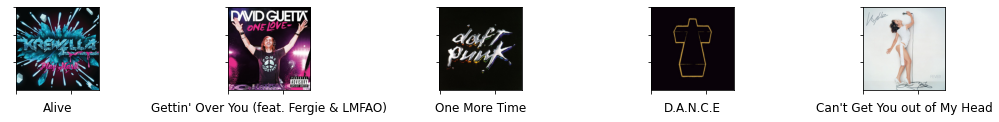

In [67]:
visualize_songs(playlist_EDM)

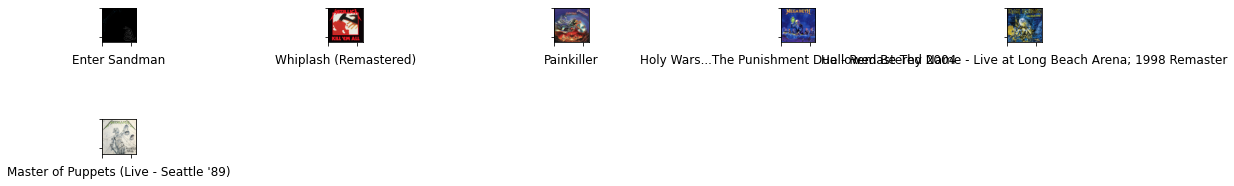

In [68]:
visualize_songs(playlist_Metal)

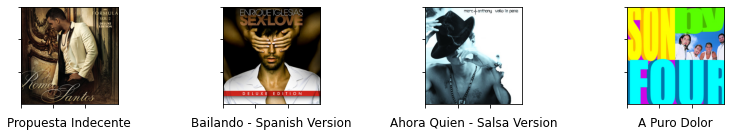

In [69]:
visualize_songs(playlist_Latin)

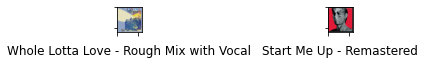

In [70]:
visualize_songs(playlist_Rock)

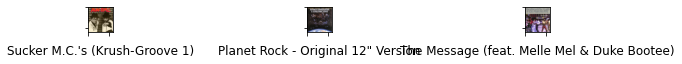

In [53]:
visualize_songs(playlist_Hip_Hop)

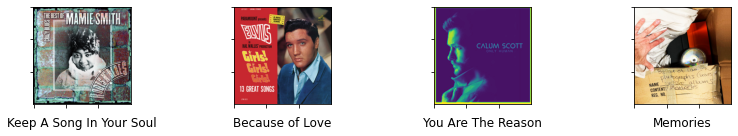

In [63]:
visualize_songs(playlist_English_songs)

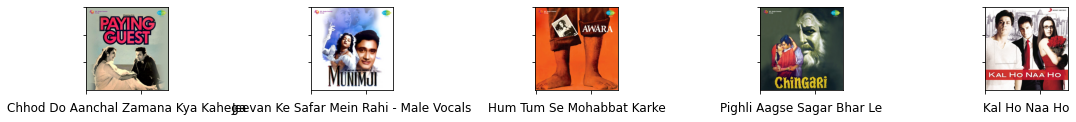

In [73]:
visualize_songs(playlist_Hindi_songs)

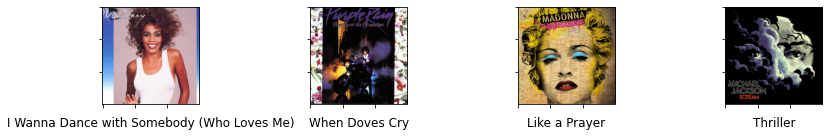

In [74]:
visualize_songs(playlist_Pop)

## 4. Create Playlist Vector

In [54]:
def generate_playlist_feature(complete_feature_set, playlist_df, weight_factor):
    """ 
    Summarize a user's playlist into a single vector

    Parameters: 
        complete_feature_set (pandas dataframe): Dataframe which includes all of the features for the spotify songs
        playlist_df (pandas dataframe): playlist dataframe
        weight_factor (float): float value that represents the recency bias. The larger the recency bias, the most priority recent songs get. Value should be close to 1. 
        
    Returns: 
        playlist_feature_set_weighted_final (pandas series): single feature that summarizes the playlist
        complete_feature_set_nonplaylist (pandas dataframe): 
    """
    
    complete_feature_set_playlist = complete_feature_set[complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1).mean(axis =0)
    complete_feature_set_playlist = complete_feature_set_playlist.merge(playlist_df[['id','date_added']], on = 'id', how = 'inner')
    complete_feature_set_nonplaylist = complete_feature_set[~complete_feature_set['id'].isin(playlist_df['id'].values)]#.drop('id', axis = 1)
    
    playlist_feature_set = complete_feature_set_playlist.sort_values('date_added',ascending=False)

    most_recent_date = playlist_feature_set.iloc[0,-1]
    
    for ix, row in playlist_feature_set.iterrows():
        playlist_feature_set.loc[ix,'months_from_recent'] = int((most_recent_date.to_pydatetime() - row.iloc[-1].to_pydatetime()).days / 30)
        
    playlist_feature_set['weight'] = playlist_feature_set['months_from_recent'].apply(lambda x: weight_factor ** (-x))
    
    playlist_feature_set_weighted = playlist_feature_set.copy()
    #print(playlist_feature_set_weighted.iloc[:,:-4].columns)
    playlist_feature_set_weighted.update(playlist_feature_set_weighted.iloc[:,:-4].mul(playlist_feature_set_weighted.weight,0))
    playlist_feature_set_weighted_final = playlist_feature_set_weighted.iloc[:, :-4]
    #playlist_feature_set_weighted_final['id'] = playlist_feature_set['id']
    
    return playlist_feature_set_weighted_final.sum(axis = 0), complete_feature_set_nonplaylist

In [56]:
complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM = generate_playlist_feature(complete_feature_set, playlist_EDM, 1.09)
#complete_feature_set_playlist_vector_chill, complete_feature_set_nonplaylist_chill = generate_playlist_feature(complete_feature_set, playlist_chill, 1.09)

In [57]:
complete_feature_set_playlist_vector_EDM.shape

(3329,)

In [78]:
complete_feature_set_playlist_vector_Metal, complete_feature_set_nonplaylist_Metal = generate_playlist_feature(complete_feature_set, playlist_Metal, 1.09)

In [76]:
complete_feature_set_playlist_vector_Latin, complete_feature_set_nonplaylist_Latin = generate_playlist_feature(complete_feature_set, playlist_Latin, 1.09)

In [83]:
complete_feature_set_playlist_vector_Rock, complete_feature_set_nonplaylist_Rock = generate_playlist_feature(complete_feature_set, playlist_Rock, 1.09)

In [55]:
complete_feature_set_playlist_vector_Hip_Hop, complete_feature_set_nonplaylist_Hip_Hop = generate_playlist_feature(complete_feature_set, playlist_Hip_Hop, 1.09)

In [88]:
complete_feature_set_playlist_vector_Pop, complete_feature_set_nonplaylist_Pop = generate_playlist_feature(complete_feature_set, playlist_Pop, 1.09)

In [65]:
complete_feature_set_playlist_vector_English_songs, complete_feature_set_nonplaylist_English_songs = generate_playlist_feature(complete_feature_set, playlist_English_songs, 1.09)

In [72]:
complete_feature_set_playlist_vector_Hindi_songs, complete_feature_set_nonplaylist_Hindi_songs = generate_playlist_feature(complete_feature_set, playlist_Hindi_songs, 1.09)

## 5. Generate Recommendations

In [56]:
def generate_playlist_recos(df, features, nonplaylist_features):
    """ 
    Pull songs from a specific playlist.

    Parameters: 
        df (pandas dataframe): spotify dataframe
        features (pandas series): summarized playlist feature
        nonplaylist_features (pandas dataframe): feature set of songs that are not in the selected playlist
        
    Returns: 
        non_playlist_df_top_20: Top 20 recommendations for that playlist
    """
    
    non_playlist_df = df[df['id'].isin(nonplaylist_features['id'].values)]
    non_playlist_df['sim'] = cosine_similarity(nonplaylist_features.drop('id', axis = 1).values, features.values.reshape(1, -1))[:,0]
    non_playlist_df_top_20 = non_playlist_df.sort_values('sim',ascending = False).head(20)
    non_playlist_df_top_20['url'] = non_playlist_df_top_20['id'].apply(lambda x: sp.track(x)['album']['images'][1]['url'])
    
    return non_playlist_df_top_20

In [62]:
edm_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_EDM, complete_feature_set_nonplaylist_EDM)

In [63]:
edm_top20

acousticness                                            artists  \
139706      0.038100                                 ['Britney Spears']   
133841      0.017500  ['Christina Aguilera', "Lil' Kim", 'Mýa', 'P!nk']   
38460       0.226000                                         ['Selena']   
139714      0.415000                                 ['Britney Spears']   
139718      0.000811                                 ['Britney Spears']   
91900       0.003050                                 ['Jennifer Lopez']   
91895       0.030300                                 ['Jennifer Lopez']   
139715      0.579000                                 ['Britney Spears']   
81163       0.004980                                          ['Kesha']   
81164       0.014100                                          ['Kesha']   
81166       0.006570                                          ['Kesha']   
54259       0.001080                                           ['P!nk']   
81987       0.001250                                     ['Katy Perry']   
62860       0.014900                                    ['Miley Cyrus']   
81981       0.000802                                     ['Katy Perry']   
38494       0.054900                                   ['Selena Gomez']   
81985       0.000417                                     ['Katy Perry']   
126658      0.004320                                    ['Demi Lovato']   
145541      0.004080                                        ['Beyoncé']   
54264       0.002340                                           ['P!nk']   

        danceability  duration_ms  energy  explicit                      id  \
139706         0.682       198600   0.894         0  5p0KCAuu5nrHpTuAIhHdLw   
133841         0.756       264847   0.808         0  7GQqj9jRtDkMp8zByehXQI   
38460          0.415       403640   0.938         0  2e5lffoLF7p6YeGbcmigdX   
139714         0.847       203600   0.843         0  6ldwfK0yWgTAlmIfuQkTYN   
139718         0.709       186533   0.728         0  29viePXNqWUw1cxqzOcuOD   
91900          0.786       221227   0.842         0  1fgvJXlcZ7uIddMpqsqw0L   
91895          0.775       211493   0.729         1  7fFCnttacpotkyhTOxKv14   
139715         0.534       231067   0.543         0  1xg1yGPy1Y3YUf44s6TB1o   
81163          0.711       211920   0.700         0  7EQGXaVSyEDsCWKmUcfpLk   
81164          0.742       230747   0.706         1  1sNctqVr9zdS7i1RZNjIgY   
81166          0.558       214307   0.781         0  4bO6IzKXMWhmncfIO9GBq2   
54259          0.802       192533   0.904         0  02jcEwywffn3Tsb48fXmlW   
81987          0.649       230747   0.815         0  455AfCsOhhLPRc68sE01D8   
62860          0.692       190453   0.911         0  0G71WvIkF2K6HViJeFvOcM   
81981          0.687       227333   0.792         0  3oL3XRtkP1WVbMxf7dtTdu   
38494          0.796        50613   0.766         0  5U4wYRHrCRxRP6iQfM824C   
81985          0.678       216160   0.918         0  1nZzRJbFvCEct3uzu04ZoL   
126658         0.585       226253   0.927         0  33RJ3P6wc0B0FIyDalhNTv   
145541         0.925       379120   0.728         0  3W1mdCYUHWewrVXnRsPntM   
54264          0.621       210693   0.849         0  1BfRdnfPYrni7zj4ANodBX   

        instrumentalness  key  liveness  loudness  mode  \
139706          0.000000    0    0.4160    -1.730     0   
133841          0.000004    5    0.6600    -3.655     1   
38460           0.009730   10    0.8030    -4.948     1   
139714          0.000134    5    0.1070    -3.579     0   
139718          0.105000    9    0.5640    -1.643     1   
91900           0.000004    4    0.4730    -5.115     0   
91895           0.002470    1    0.0361    -4.229     0   
139715          0.000000    3    0.1120    -6.857     1   
81163           0.000125    1    0.2150    -4.805     0   
81164           0.005680    0    0.1330    -4.600     0   
81166           0.001440    1    0.1020    -5.448     0   
54259           0.000000   11    0.1730    -3.267     0   
81987

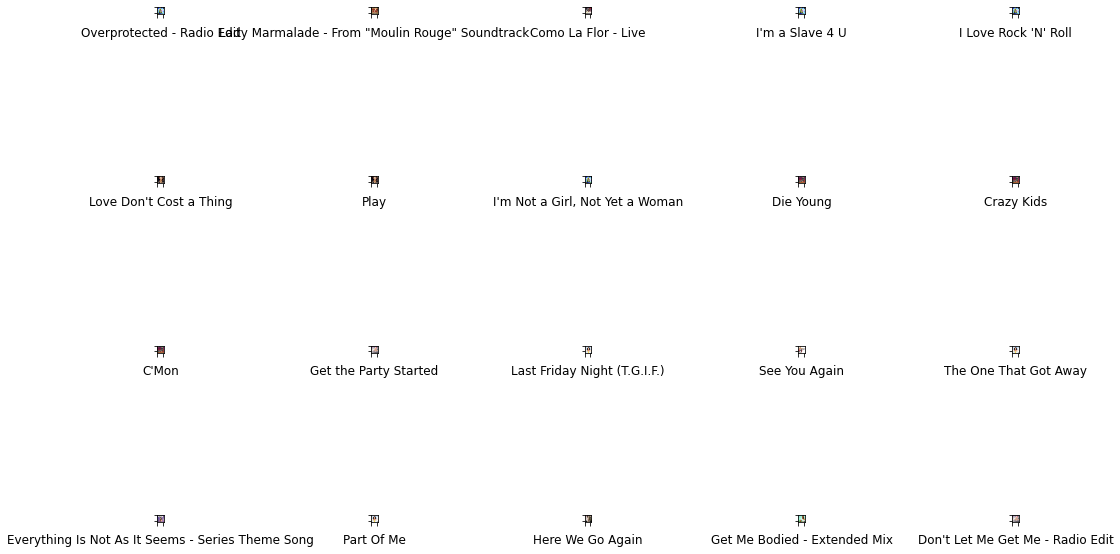

In [64]:
visualize_songs(edm_top20)

In [65]:
edm_top20.to_csv("edm_top20.csv")

In [70]:
metal_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_Metal, complete_feature_set_nonplaylist_Metal)

In [71]:
metal_top20

acousticness        artists  danceability  duration_ms  energy  \
64558      0.000016  ['Metallica']         0.314       330467   0.990   
64602      0.000004  ['Metallica']         0.257       397260   0.995   
64546      0.002480  ['Metallica']         0.196       257211   0.998   
64512      0.000668  ['Metallica']         0.438       446146   0.687   
64545      0.000043  ['Metallica']         0.249       255867   0.970   
64540      0.006170  ['Metallica']         0.290       281293   0.911   
64523      0.000116  ['Metallica']         0.289       187840   0.938   
64473      0.000089  ['Metallica']         0.432       395102   0.906   
64470      0.000447  ['Metallica']         0.475       233893   0.924   
64482      0.000052  ['Metallica']         0.483       463159   0.909   
64521      0.000297  ['Metallica']         0.584       409640   0.816   
64573      0.003270  ['Metallica']         0.639       385987   0.838   
64578      0.000019  ['Metallica']         0.404       313045   0.948   
64484      0.000005  ['Metallica']         0.309       360155   0.993   
64589      0.000004  ['Metallica']         0.301       470380   0.993   
64518      0.000297  ['Metallica']         0.296       386560   0.915   
64594      0.000254  ['Metallica']         0.371       343780   0.856   
64493      0.036400  ['Metallica']         0.439       414720   0.963   
64481      0.000477  ['Metallica']         0.563       308533   0.800   
64469      0.000019  ['Metallica']         0.304       428310   0.986   

       explicit                      id  instrumentalness  key  liveness  \
64558         1  7MzM6iHyRYmuWBIm75DqHC          0.097800    6    0.6400   
64602         1  2PFoYVONNUOm7HHkTAJers          0.123000    6    0.4750   
64546         0  77aAF7Pafxq6T5Fa7JBbzf          0.243000    4    0.3060   
64512         0  0LAcM6I7ijW4VVW0aytl1t          0.080100    7    0.4200   
64545         0  4OH1lqC4mx1ja8RkXMOmRp          0.224000    4    0.1380   
64540         0  1gXXgZzrqexEhWa5Fg7VoA          0.010800    5    0.3310   
64523         0  1QQgmN383kUqjioRoTSfF3          0.061500    1    0.1060   
64473         0  2Rn5VhDVELkuB4BjZEVJKr          0.044800    9    0.1560   
64470         0  6RlsFZUCF3bU4NE7BjpDXr          0.040800    0    0.2270   
64482         0  2ZTequNqaDxvv5N7tFrsl9          0.051200    4    0.1190   
64521         0  6YwqziI3H71IMishKRTHHg          0.015100    9    0.1020   
64573         0  1WnEyhN7Gdu23DQvUZkQy8          0.007140   11    0.0834   
64578         1  4bAQzjDk9ONZ8gvm5YKEGE          0.040500    6    0.0773   
64484         1  7naRIEBtd0qOU8r9WYumqZ          0.374000    8    0.7580   
64589         1  4EcsR2fMms1TXY44F1Yz6v          0.428000   11    0.8390   
64518         0  7klyZXrpJD8GqVE9QYYy4A          0.346000    9    0.3620   
64594         0  3Sb6LD52wTQaFKmc3UHmZG          0.136000    0    0.6060   
64493         0  5DrNFzZZZVfXaEZCaceKnp          0.008960    9    0.0784   
64481         0  0h26wQZD5GoSvK5zZuv69E          0.000523    8    0.1180   
64469         1  6wqv1OIgD5Z3PjfOaayDix          0.225000    8    0.9870   

       loudness  mode                                               name  \
64558    -5.514     0       For Whom the Bell Tolls (Live - Seattle '89)   
64602    -5.811     0                     Blackened (Live - Seattle '89)   
64546    -3.410     1  Hit The Lights (Live at Espace Balard, Paris, ...   
64512    -9.150     1                                   One (Remastered)   
64545    -5.535     0                        Hit The Lights (Remastered)   
64540    -5.667     0                      Jump In The Fire (Remastered)   
64523    -6.083     1                           Motorbreath (Remastered)   
64473    -7.958     1                    The Shortest Straw (Remastered)   
64470    -7.351     1                                The Struggle Within   
64482    -7.296     0             The Frayed Ends of Sanity (Remastered)   
64521    -8.101     0                   

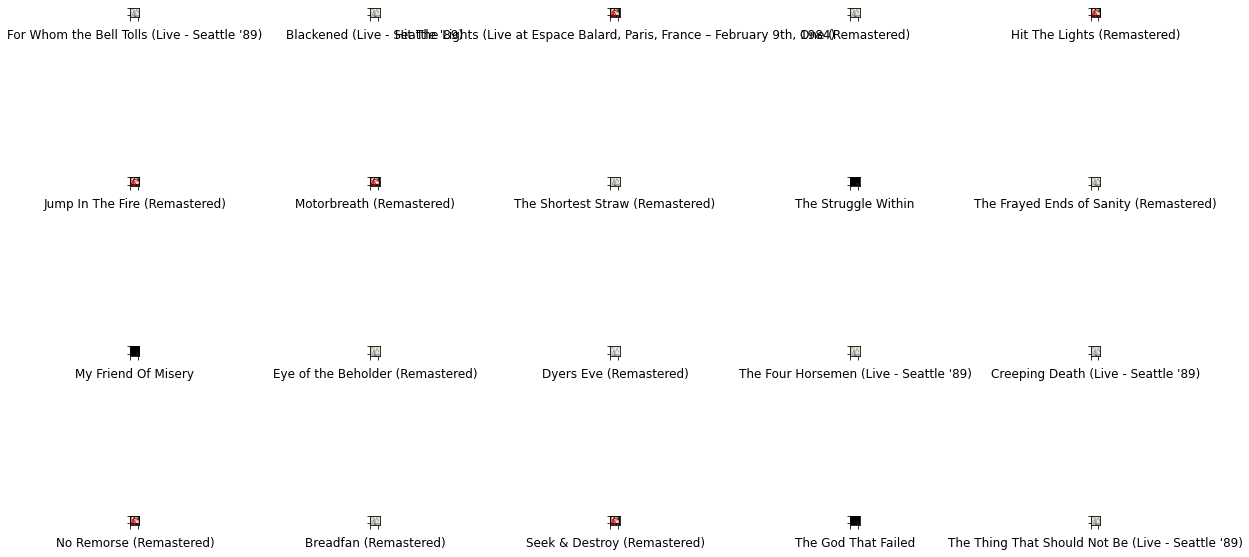

In [72]:
visualize_songs(metal_top20)

In [73]:
metal_top20.to_csv("metal_top20.csv")

In [79]:
latin_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_Latin, complete_feature_set_nonplaylist_Latin)

In [80]:
latin_top20

acousticness                               artists  danceability  \
42242         0.3960      ['Romeo Santos', 'Marc Anthony']         0.645   
118542        0.4040  ['Enrique Iglesias', 'Romeo Santos']         0.756   
135018        0.1120                          ['Chayanne']         0.690   
42263         0.4170                      ['Romeo Santos']         0.854   
42260         0.5740                      ['Romeo Santos']         0.783   
42255         0.3590                      ['Romeo Santos']         0.733   
42257         0.3460                      ['Romeo Santos']         0.872   
42262         0.1890                      ['Romeo Santos']         0.826   
42258         0.4010                      ['Romeo Santos']         0.843   
121513        0.0857                      ['Eddy Herrera']         0.699   
119703        0.4980                      ['Elvis Crespo']         0.753   
119702        0.2380                      ['Elvis Crespo']         0.809   
68367         0.3980                      ['Marc Anthony']         0.691   
134544        0.2790                    ['ChiChi Peralta']         0.805   
119706        0.4420                      ['Elvis Crespo']         0.802   
119704        0.4750                      ['Elvis Crespo']         0.801   
119705        0.4520                      ['Elvis Crespo']         0.691   
119701        0.4020                      ['Elvis Crespo']         0.794   
134545        0.2920                    ['ChiChi Peralta']         0.820   
135006        0.1890                          ['Chayanne']         0.573   

        duration_ms  energy  explicit                      id  \
42242        306453   0.786         0  5A9AILetvfQg3LHyX5X0pV   
118542       213147   0.863         0  6yjsa6c8nSGQqXF12vFSpp   
135018       225987   0.902         0  7lOzUJzsELALh5FQsPKTEn   
42263        253200   0.751         0  3sTVMGhTdyyLM67WyYhYMB   
42260        237093   0.781         0  6bcdiJvYNX115yvbh3wASz   
42255        236293   0.794         0  6rXvMpWJbTyhSrVWye7jPE   
42257        234760   0.726         0  6CKlQHQIxhWtq7MnEJ6QCz   
42262        231587   0.753         0  4n82bvvKnaCSbM0pXWbR1S   
42258        250640   0.729         0  6I86RF3odBlcuZA9Vfjzeq   
121513       300427   0.841         0  25ILWrCvXPpkUFU0R7znEv   
119703       259067   0.895         0  7gNI9f8NTCU6hLV0pLkTT7   
119702       266307   0.883         0  1YwPNemawMgGe6sF4U0FTE   
68367        300160   0.658         0  3yEtuhGR8jOtusa29jWrhG   
134544       271031   0.757         0  2q9udNV9NK0BL3q9p6TLxf   
119706       265667   0.944         0  7zOqkF9TUdUPREtkIf1v4Q   
119704       287507   0.905         0  4d8LZYb5qstwWaUnXR3Co4   
119705       208800   0.891         0  2yB721Szta49XabGt5FQ0u   
119701       273053   0.908         0  2pPgF067E3mtYhA5paJfcI   
134545       275200   0.838         0  6Fu5E5nuKfVOecwBmWLi7O   
135006       288947   0.642         0  2sKo5u6IppUEudIz265wYa   

        instrumentalness  key  liveness  loudness  mode  \
42242           0.000000    4    0.1110    -4.248     0   
118542          0.000000    7    0.1120    -3.390     1   
135018          0.000000    6    0.1750    -4.269     0   
42263           0.000003    6    0.0894    -5.243     1   
42260           0.000000    4    0.3230    -3.079     1   
42255           0.000000    5    0.1600    -4.328     1   
42257           0.000000    5    0.1140    -3.513     0   
42262           0.000000   11    0.2300    -4.514     0   
42258           0.000001    6    0.2060    -3.634     0   
121513          0.000035    2    0.2940    -7.911     1   
119703          0.000039    9    0.0431    -2.385     0   
119702          0.002340    8    0.0625    -2.965     1   
68367           0.000046    0    0.1120    -6.496     1   
134544          0.000839    8    0.1010    -7.460     1   
119706          0.002900    9    0.1060    -3.531     1   
119704          0.005700    9    0.0456    -3.122     1   
119705          0.001740    3    0.2370   

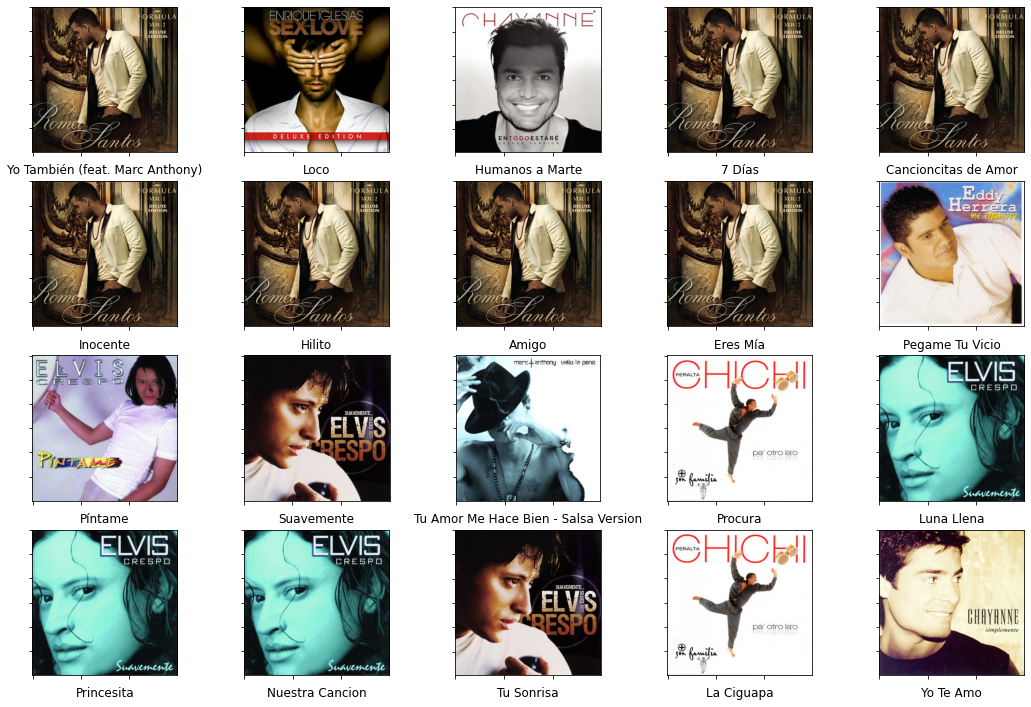

In [81]:
visualize_songs(latin_top20)

In [82]:
latin_top20.to_csv("latin_top20.csv")

In [84]:
rock_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_Rock, complete_feature_set_nonplaylist_Rock)

In [85]:
rock_top20

acousticness                                      artists  \
77333      0.048400                             ['Led Zeppelin']   
18299      0.170000  ['The Rolling Stones', 'Bob Clearmountain']   
18244      0.115000                       ['The Rolling Stones']   
18383      0.029900  ['The Rolling Stones', 'Bob Clearmountain']   
10493      0.044800                                ['Van Halen']   
18330      0.132000                       ['The Rolling Stones']   
77449      0.000124                             ['Led Zeppelin']   
77447      0.000942                             ['Led Zeppelin']   
10494      0.003450                                ['Van Halen']   
77404      0.153000                             ['Led Zeppelin']   
10553      0.007580                                ['Van Halen']   
10535      0.009160                                ['Van Halen']   
10477      0.014500                                ['Van Halen']   
18339      0.433000                       ['The Rolling Stones']   
10512      0.005850                                ['Van Halen']   
18327      0.007800                       ['The Rolling Stones']   
18340      0.433000                       ['The Rolling Stones']   
18329      0.008690                       ['The Rolling Stones']   
18185      0.157000                       ['The Rolling Stones']   
77531      0.144000                             ['Led Zeppelin']   

       danceability  duration_ms  energy  explicit                      id  \
77333         0.412       333893   0.902         0  0hCB0YR03f6AmQaHbwWDe8   
18299         0.431       211467   0.940         0  1nBufEoW7UXvQWgqmNl6Kx   
18244         0.564       392800   0.862         0  0oM5Z3MGSOieWT6ObRQ2Uj   
18383         0.461       141093   0.906         0  5HcTLesmMaPr0CkwdbtK0o   
10493         0.321       185271   0.927         0  6GY1Wq4k1N0CI5VlfrIeiZ   
18330         0.530       203173   0.888         0  7K3rmA4f6NEElsxKEOOt8H   
77449         0.476       159667   0.828         0  4CWaV1xRCEJQj0QJJif60x   
77447         0.475       159301   0.808         0  49C6EGQhCUSgyADHYvJ7ez   
10494         0.472       188017   0.923         0  0LU1gfHjfUdSg32Yg4H1P9   
77404         0.253       126973   0.887         0  2O1SBvPLma0j6IQXT1jeaM   
10553         0.387       247386   0.782         0  63Kyj8FRdQHbSHgdNb74Le   
10535         0.515       272034   0.815         0  3tswCUETEyhBqxvDwfvGs3   
10477         0.528       209206   0.875         0  6fHS0zmDdDKktklfaqojaF   
18339         0.560       327827   0.700         0  3hOyB6eLLjeadJD3rIodMd   
10512         0.481       300491   0.902         0  1eGSgC6ZhJ8D4nrZZ83LyA   
18327         0.676       213027   0.666         0  3r7znjZZm0lz9wSuhKqdHb   
18340         0.558       327880   0.684         0  06FcMPcosZg13x2QODDDK6   
18329         0.681       213133   0.633         0  31YMV7aMItO8jzyc10iRrS   
18185         0.606       274227   0.794         0  4Wd9pEtEnZNDjgiswGOpJb   
77531         0.375       150201   0.956         0  2E64SWjM9rQmAshItmdbcw   

       instrumentalness  key  liveness  loudness  mode  \
77333          0.131000    9    0.4050   -11.600     1   
18299          0.001550    9    0.3150    -5.868     1   
18244          0.308000    9    0.0493    -6.398     1   
18383          0.010400    9    0.3190    -4.369     1   
10493          0.000000    6    0.2390    -4.663     1   
18330          0.032100    5    0.4250    -5.128     1   
77449          0.000023    9    0.0569    -8.060     1   
77447          0.000008    9    0.1460    -8.859     1   
10494          0.000115    8    0.3150    -5.074     1   
77404          0.000001    4    0.2780    -4.763     1   
10553          0.000970    1    0.1070    -8.318     1   
10535          0.000003    6    0.0966    -6.349     1   
10477          0.000000    1    0.1380    -5.912     1   
18339          0.003340    0    0.1700    -7.765     1   
10512          0.000121    1    0.0722    -7.430     1   
18327      

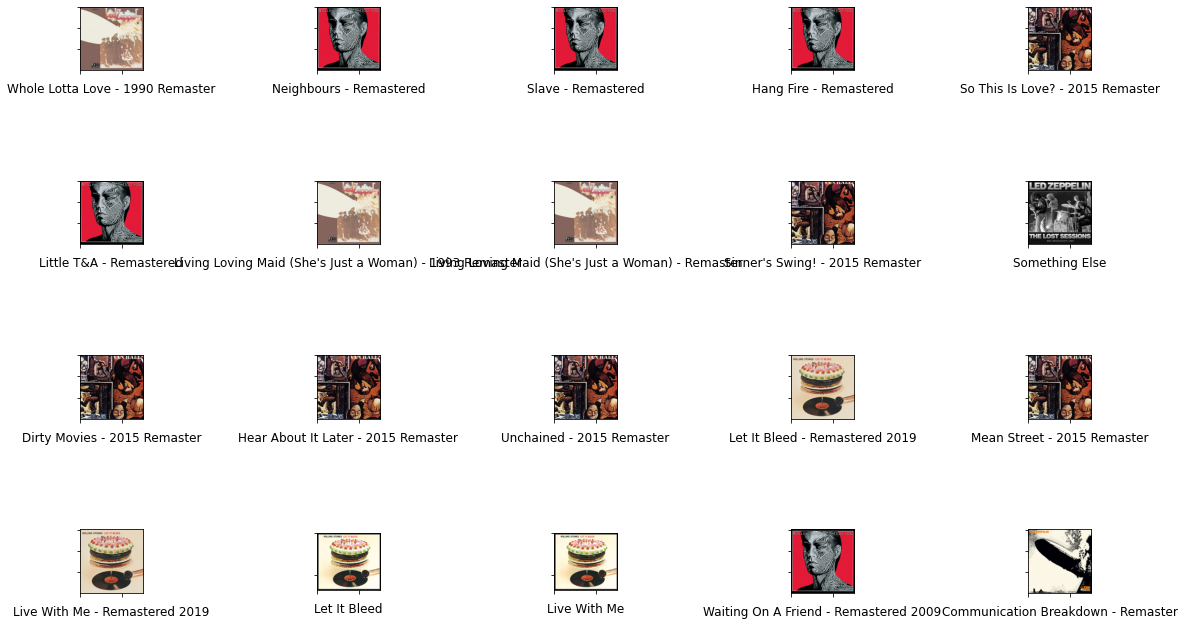

In [86]:
visualize_songs(rock_top20)

In [87]:
rock_top20.to_csv("rock_top20.csv")

In [89]:
pop_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_Pop, complete_feature_set_nonplaylist_Pop)

In [90]:
pop_top20

acousticness                           artists  danceability  \
69344       0.33300                       ['Madonna']         0.742   
27563       0.05270                  ['Taylor Swift']         0.613   
69367       0.05420                       ['Madonna']         0.854   
69370       0.01080                       ['Madonna']         0.667   
69318       0.00379                       ['Madonna']         0.737   
27524       0.07130                  ['Taylor Swift']         0.800   
27526       0.00465                  ['Taylor Swift']         0.562   
69362       0.06580                       ['Madonna']         0.729   
69357       0.39200                       ['Madonna']         0.708   
69338       0.37700                       ['Madonna']         0.673   
69383       0.21600                       ['Madonna']         0.771   
69343       0.21900                       ['Madonna']         0.739   
69327       0.14100  ['Madonna', 'Jellybean Benitiz']         0.736   
27517       0.06790                  ['Taylor Swift']         0.696   
27456       0.01560                  ['Taylor Swift']         0.567   
69389       0.29600                       ['Madonna']         0.752   
27501       0.20400                  ['Taylor Swift']         0.766   
69334       0.58500                       ['Madonna']         0.875   
69387       0.08200                       ['Madonna']         0.807   
69326       0.32800                       ['Madonna']         0.740   

       duration_ms  energy  explicit                      id  \
69344       240280   0.883         0  22sLuJYcvZOSoLLRYev1s5   
27563       208187   0.764         0  2yLa0QULdQr0qAIvVwN6B5   
69367       368280   0.796         0  4k6ktr10Hczmh55NY3LfJy   
69370       239093   0.930         0  6ioBgySxoeQKALvAeLEmId   
69318       316813   0.880         0  27QvYgBk0CHOVHthWnkuWt   
27524       209680   0.535         0  1ZY1PqizIl78geGM4xWlEA   
27526       233627   0.689         0  0VE4kBnHJUgtMf0dy6DRmW   
69362       285093   0.856         0  2m0M7YqCy4lXfedh18qd8N   
69357       242947   0.832         0  2Iib2MV3ECFJAourgP9dlY   
69338       252373   0.792         0  0uIqV0X1M1vjti0ubMOInt   
69383       261667   0.749         0  3sX3c6QUPSAiKf77RZRf5B   
69343       369547   0.731         0  4vle25yO4Rf7AYkWtzSfAS   
69327       383507   0.714         0  73WYe6TI6bdfmvnezJ5GvV   
27517       238253   0.602         0  4svZDCRz4cJoneBpjpx8DJ   
27456       207133   0.789         0  07NxDD1iKCHbAldceD7QLP   
69389       236133   0.593         0  7ov1nZ2QZc3LIuCXXERZP0   
27501       211853   0.709         0  1P17dC1amhFzptugyAO7Il   
69334       271307   0.597         0  0S9EixwOfXC0LyILi8kVFh   
69387       238360   0.764         0  4FMNpPI7mkhdeFCCk6fZiE   
69326       244747   0.588         0  19gLqMCui3hxPDTKTEoELa   

       instrumentalness  key  liveness  loudness  mode  \
69344          0.000008    0    0.0964    -3.419     1   
27563          0.000000    2    0.1970    -6.509     1   
69367          0.001840   11    0.1510    -5.567     0   
69370          0.000000    7    0.1760    -4.585     1   
69318          0.003510    6    0.4170    -6.449     1   
27524          0.000009    7    0.2130    -6.684     1   
27526          0.000002    2    0.0888    -6.745     1   
69362          0.008320   10    0.0691    -4.164     0   
69357          0.000001    1    0.0561    -4.736     0   
69338          0.002790    5    0.0578   -10.843     1   
69383          0.001840    5    0.1350   -10.628     0   
69343          0.000077    0    0.0801   -12.685     1   
69327          0.000005    9    0.0406   -11.136     0   
27517          0.000021    0    0.0696    -6.156     0   
27456          0.000000    5    0.3820    -5.986     1   
69389          0.000196    7    0.1680   -13.673     1   
27501          0.000014    9    0.1260    -6.471     0   
69334          0.000018    9    0.0706   -11.916     0   
69387          0.000039    2    0.1150    -5.186     1   
69326     

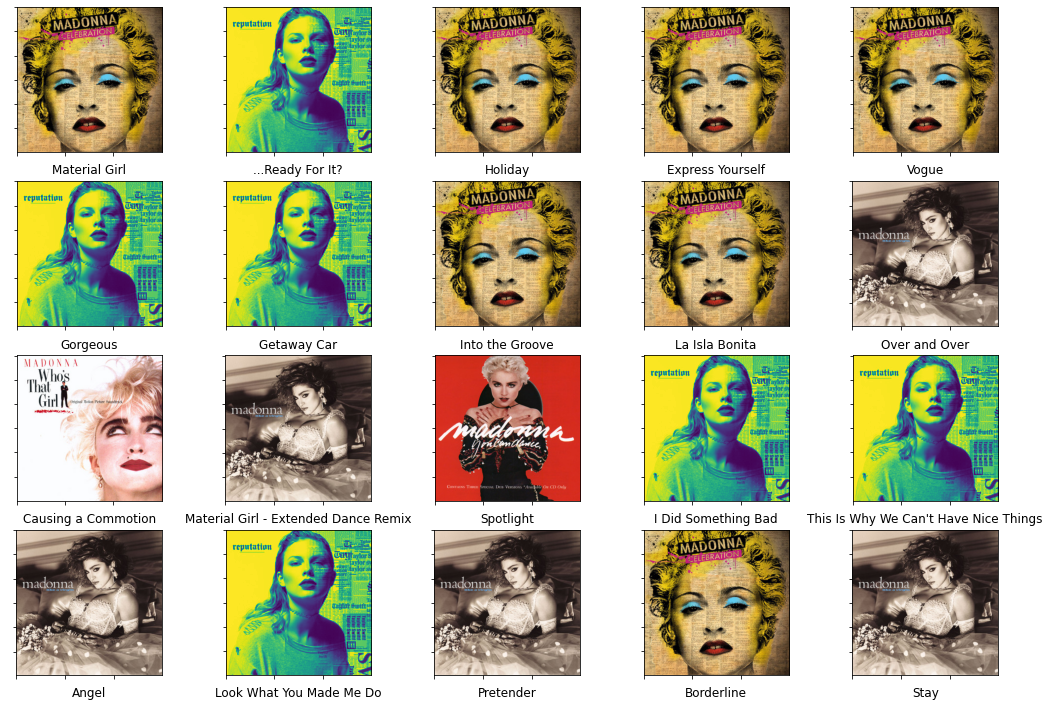

In [91]:
visualize_songs(pop_top20)

In [92]:
pop_top20.to_csv("pop_top20.csv")

In [68]:
english_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_English_songs, complete_feature_set_nonplaylist_English_songs)

In [69]:
english_top20

acousticness            artists  danceability  duration_ms  energy  \
137953        0.8390    ['Calum Scott']         0.682       260285   0.173   
67234         0.5580       ['Maroon 5']         0.611       215230   0.462   
67201         0.0946       ['Maroon 5']         0.658       190643   0.603   
140505        0.3500   ['Boyce Avenue']         0.349       212772   0.366   
31099         0.7000  ['Summer Walker']         0.759       143667   0.413   
10314         0.4840      ['Vance Joy']         0.637       214720   0.864   
31104         0.6260  ['Summer Walker']         0.646        92093   0.335   
87350         0.3250     ['John Mayer']         0.828       216015   0.689   
93786         0.6030    ['James Blunt']         0.679       213053   0.540   
93787         0.9530    ['James Blunt']         0.432       258653   0.261   
10317         0.8050      ['Vance Joy']         0.657       239787   0.396   
119592        0.8180  ['Elvis Presley']         0.518       135013   0.474   
93793         0.1770      ['James Bay']         0.559       181360   0.473   
119582        0.8490  ['Elvis Presley']         0.613       151893   0.867   
87360         0.6150     ['John Mayer']         0.556       285480   0.528   
68937         0.9920    ['Mamie Smith']         0.574       189800   0.138   
31097         0.8940  ['Summer Walker']         0.574        98027   0.123   
119324        0.8160  ['Elvis Presley']         0.730       155600   0.473   
31106         0.6370  ['Summer Walker']         0.693       203240   0.369   
68940         0.9930    ['Mamie Smith']         0.647       163827   0.186   

        explicit                      id  instrumentalness  key  liveness  \
137953         0  2BOqDYLOJBiMOXShCV1neZ          0.000033    1    0.0983   
67234          0  6OEHjJJvdkk1Ln0p0AZdyz          0.000001    0    0.1310   
67201          0  4egTUh77H4Zim2gwMPSKt7          0.000000    8    0.1070   
140505         0  4Dl855fAN0nKsqlpsuh8pG          0.000000    6    0.6100   
31099          1  4hWgC5BV5M7EtTleKVXNxw          0.000000   11    0.1400   
10314          0  2RiBogNRfulkNf7fVbPOrJ          0.000000    8    0.2220   
31104          1  3LfHBTYZBTqmz43tvVXJBd          0.000013    3    0.1070   
87350          0  3bH4HzoZZFq8UpZmI2AMgV          0.038400    7    0.0808   
93786          0  6GU19qDSbCWw5HKwfYTgVq          0.000017    0    0.0905   
93787          0  6gxycjJNMgmAyfzUXBN80P          0.003420    4    0.0903   
10317          0  6Qwuw0eOeszVlewLpu24gR          0.000002    7    0.1030   
119592         0  7px5NjaMpVhlVlH00OhCIf          0.004220    3    0.2190   
93793          0  16XiTUC2rQvb5lmtOm3FYY          0.000002    0    0.1080   
119582         0  3gRY13yzIA4VyqwvEyu7ot          0.000000   10    0.2360   
87360          0  1HNywa8Bk0TmzRwQrzhtPo          0.096400    4    0.1220   
68937          0  4HYmmG8uHL2hP4zSFWavKF          0.000492    3    0.2330   
31097          0  2ktg2oZDyFAX3iY1QNkXl5          0.001110    1    0.1180   
119324         0  2zaW217xazLQjldSjJmCgj          0.035400    2    0.1120   
31106          0  5Tp4UJvnsF4Zd05k0zXUte          0.003350    7    0.0951   
68940          0  11m7laMUgmOKqI3oYzuhne          0.000018    0    0.5190   

        loudness  mode                                               name  \
137953    -8.749     1                                  Dancing On My Own   
67234     -7.054     1                                     Girls Like You   
67201     -5.016     1                                               Wait   
140505    -7.550     1  A Thousand Years / Say You Won’t Let Go (Live ...   
31099     -7.282     0                                      Playing Games   
10314     -4.381     1                                       Saturday Sun   
31104     -9.915     0                                               Deep   
87350     -7.878     1                                          New Light   
93786     -7.457     0                                   Y

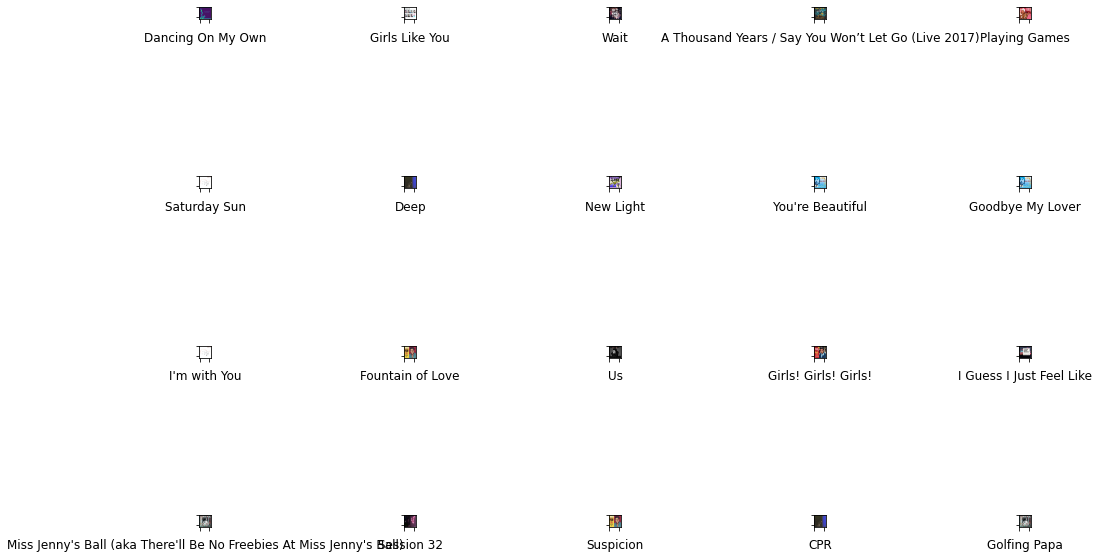

In [75]:
visualize_songs(english_top20)

In [70]:
english_top20.to_csv("english_top20.csv")

In [73]:
hindi_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_Hindi_songs, complete_feature_set_nonplaylist_Hindi_songs)

In [76]:
hindi_top20

acousticness                                            artists  \
80349          0.879                                  ['Kishore Kumar']   
80341          0.977                                  ['Kishore Kumar']   
80375          0.977  ['Kishore Kumar', 'Mohammed Rafi', 'Ram Kamlani']   
80320          0.902                                  ['Kishore Kumar']   
80327          0.973                                  ['Kishore Kumar']   
80339          0.755                                  ['Kishore Kumar']   
78548          0.985               ['Lata Mangeshkar', 'Kishore Kumar']   
78213          0.993               ['Lata Mangeshkar', 'Kishore Kumar']   
80337          0.944                   ['Kishore Kumar', 'Asha Bhosle']   
80372          0.961                                  ['Kishore Kumar']   
149442         0.980                   ['Asha Bhosle', 'Kishore Kumar']   
80376          0.978               ['Kishore Kumar', 'Usha Mangeshkar']   
80378          0.904                                  ['Kishore Kumar']   
80351          0.925                                  ['Kishore Kumar']   
80344          0.839                                  ['Kishore Kumar']   
80359          0.858               ['Kishore Kumar', 'Lata Mangeshkar']   
80338          0.961                                  ['Kishore Kumar']   
80342          0.925                                  ['Kishore Kumar']   
80346          0.974                                  ['Kishore Kumar']   
149524         0.873                   ['Asha Bhosle', 'Kishore Kumar']   

        danceability  duration_ms  energy  explicit                      id  \
80349          0.685       247194   0.503         0  1vsR89NNnQ0YUxC4fZcoVA   
80341          0.615       193701   0.372         0  2FdSHzDpEO1QQhmJe8YNo1   
80375          0.694       187405   0.383         0  28NXCGzSUsrRTpV8doJFyy   
80320          0.546       190691   0.470         0  15ShOUsytFAXJiIfNR9Iml   
80327          0.780       178361   0.425         0  0VldGT1w3A5lPJaU29DNNE   
80339          0.515       155013   0.612         0  1WnwFA8HIJdLviWvSI123c   
78548          0.273       192333   0.198         0  09aFzJT56dpsZfN8O2oR6U   
78213          0.398       187680   0.364         0  2FcgWJbmaAlw3D9TSrJ3Lg   
80337          0.504       227267   0.322         0  22FKMxkCJexl2ZNoeFNny4   
80372          0.343       187773   0.215         0  4USgZJQXWeoOEZsgcrUQL4   
149442         0.793       189667   0.376         0  36oubwXEIqrSHdJu0iIsYu   
80376          0.546       192732   0.300         0  06T1Gdqw72Q0pAtZLwU0ww   
80378          0.627       192968   0.471         0  18K6ACEONzdhMzMQfHLBPm   
80351          0.655       204720   0.424         0  7r5V50UOHran9B2ir1dNPS   
80344          0.705       172173   0.591         0  7b6QWFFhvSSKeE38zixIrd   
80359          0.512       282389   0.608         0  7nCmEUOYipfS7P9Dv6rbaX   
80338          0.873       157145   0.323         0  0OG1ND8QIAjA4OL5eOhLaW   
80342          0.517       300640   0.657         0  5mFZIAChJopXl03hzSKGZJ   
80346          0.619       145127   0.320         0  0ZGnha8rGbcGgygGMuEDlB   
149524         0.689       264707   0.636         0  1cgdSRscVORILnQul7Z1vx   

        instrumentalness  key  liveness  loudness  mode  \
80349           0.000025    6    0.3960    -6.136     0   
80341           0.000000    3    0.0968    -9.838     0   
80375           0.070300    3    0.4290   -13.135     1   
80320           0.022300    2    0.4910   -12.193     1   
80327           0.000000    3    0.7600    -6.138     1   
80339           0.000582    1    0.0855    -7.878     0   
78548           0.149000    5    0.1320   -15.998     0   
78213           0.764000    1    0.1300   -11.342     0   
80337           0.000036    5    0.1260   -14.529     1   
80372           0.000006   10    0.3730   -13.137     1   
149442          0.873000    6    0.4180   -14.925     1   
80376           0.874000    2    0.2050   -12.363     1   
80378

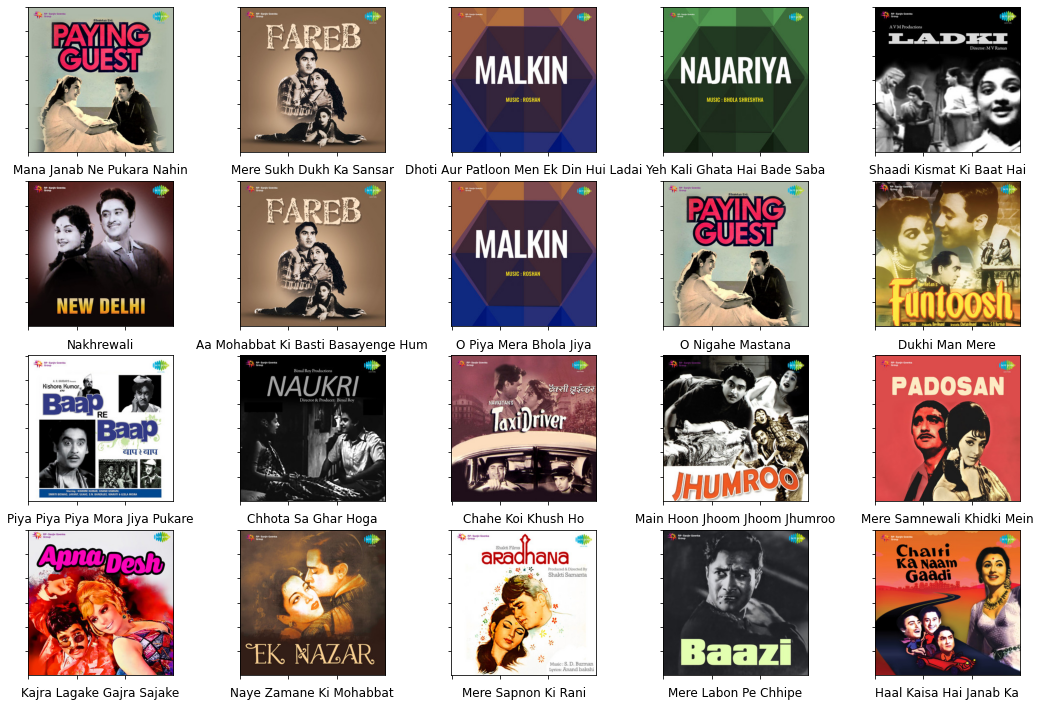

In [77]:
visualize_songs(hindi_top20)

In [78]:
hindi_top20.to_csv("hindi_top20.csv")

In [57]:
hip_hop_top20 = generate_playlist_recos(spotify_df, complete_feature_set_playlist_vector_Hip_Hop, complete_feature_set_nonplaylist_Hip_Hop)

In [58]:
hip_hop_top20

acousticness                                      artists  \
155852      0.123000  ['Afrika Bambaataa', 'The Soulsonic Force']   
30191       0.001580                                ['T La Rock']   
155851      0.011000  ['Afrika Bambaataa', 'The Soulsonic Force']   
155850      0.010900  ['Afrika Bambaataa', 'The Soulsonic Force']   
30889       0.006740       ['Supernova', 'Grandmaster Melle Mel']   
83405       0.029400                                 ['Just-Ice']   
102579      0.043800     ['Grandmaster Flash & The Furious Five']   
102584      0.015500     ['Grandmaster Flash & The Furious Five']   
102582      0.277000     ['Grandmaster Flash & The Furious Five']   
102583      0.003150     ['Grandmaster Flash & The Furious Five']   
41016       0.001930                               ['Run–D.M.C.']   
41024       0.171000                               ['Run–D.M.C.']   
41029       0.000816                               ['Run–D.M.C.']   
41033       0.000844                               ['Run–D.M.C.']   
41036       0.003940                               ['Run–D.M.C.']   
41034       0.059100                               ['Run–D.M.C.']   
41039       0.013500                               ['Run–D.M.C.']   
41038       0.266000                               ['Run–D.M.C.']   
41035       0.025500                               ['Run–D.M.C.']   
41026       0.003080                               ['Run–D.M.C.']   

        danceability  duration_ms  energy  explicit                      id  \
155852         0.784       229053   0.986         0  2bhr1LI24makfP843l4lMB   
30191          0.877       261794   0.647         0  6SuIF8oh96UPJIIJjKvtIe   
155851         0.915       319960   0.807         0  3uy0jtkM8QYVTsBazkli1x   
155850         0.821       240987   0.777         0  1N2tobz8qSty08hNk88nRF   
30889          0.786       240293   0.815         1  1DEeNOeXZDD8SnmU62onoy   
83405          0.795       272787   0.775         1  5hGsUZIjiBZq4QRtjdulKB   
102579         0.853       269053   0.703         0  3odqT6FRAUAFCeOmNFmLrb   
102584         0.925       258467   0.733         0  57CrjgdO5a1RJOAGXk8YF8   
102582         0.854       431507   0.689         1  2wfAWoybEH26oAQJAS31OL   
102583         0.837       295667   0.633         0  3oWXABQqIZ8ETgM7hxxxO5   
41016          0.962       205960   0.534         0  5m8WUAOtjHLt3y8UVPXUIm   
41024          0.777       330573   0.892         0  2XYNq7LIQrh82m7LPiPN8w   
41029          0.828       167573   0.715         0  6LdpVTJzigyi2vbKe8mZAr   
41033          0.956       183427   0.720         0  6jBCehpNMkwFVF3dz4nLIW   
41036          0.747       192840   0.960         0  2DYVOx818b5iQ0YRGrSMst   
41034          0.964       290280   0.889         0  2J6QnTjHIWwXErNWyF0RUC   
41039          0.857       232307   0.924         0  0AEDeskXKRo2E0r7ISoMAy   
41038          0.910       244160   0.954         0  6rs1Jt3bqNdPN01kQeAXX5   
41035          0.848       187107   0.763         0  40rt5qcE4k671lIT3RSH1G   
41026          0.835       195160   0.639         0  3nLsMbxcy2u57XRPhT0yzO   

        instrumentalness  key  liveness  loudness  mode  \
155852          0.000166    0    0.1840    -6.918     1   
30191           0.061800    7    0.1260    -9.652     1   
155851          0.000122    6    0.2010    -9.636     0   
155850          0.527000    6    0.0836    -6.569     0   
30889           0.000233    4    0.1560    -7.252     0   
83405           0.139000    1    0.0367    -7.492     1   
102579          0.000440    0    0.0646    -8.799     1   
102584          0.000000    1    0.2540   -10.513     1   
102582          0.008110    4    0.0527    -7.974     1   
102583          0.653000   10    0.4020   -13.530     0   
41016           0.000897   11    0.0136   -13.968     0   
41024           0.000002    0    0.3840    -4.555     1   
41029           0.000002   10    0.2760   -13.660     0   
41033           0.000000   11    0.0597   -13.476     0   
41036        

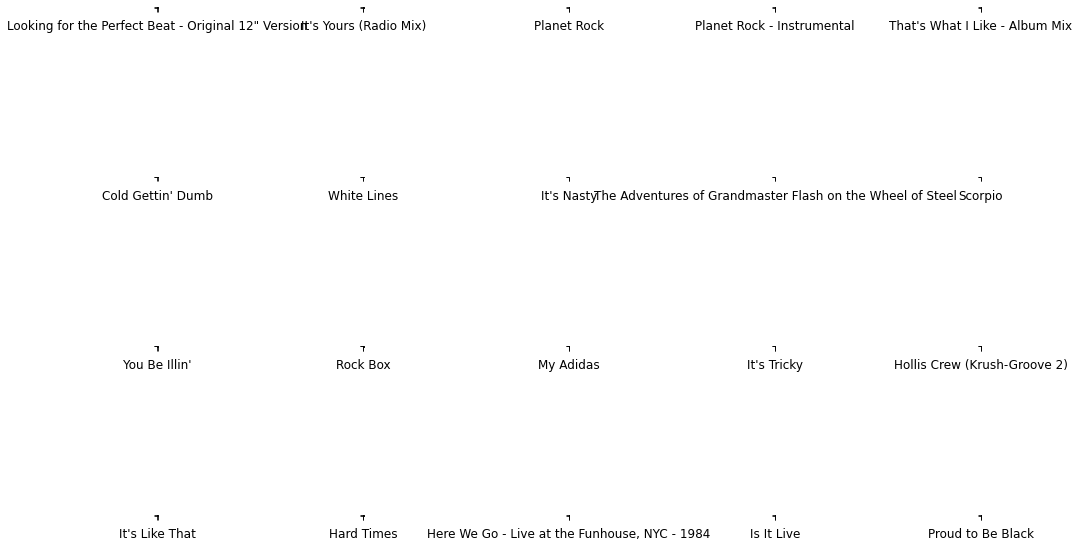

In [59]:
visualize_songs(hip_hop_top20)

In [60]:
hip_hop_top20.to_csv("hip_hop_top20.csv")